In [1]:
import mpramnist
from mpramnist.massivestarrdataset import MassiveStarrDataset
from mpramnist import transforms as t
from mpramnist import target_transforms as t_t

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import pytorch_lightning as L
from pytorch_lightning import loggers as pl_loggers
from torch.cuda.amp import autocast
from torch.nn import functional as F

In [2]:
class Simple_Net(nn.Module):
    
    def __init__(self, seq_len, block_sizes=[16, 24, 32, 40, 48], kernel_size=3):
        
        super().__init__()
        self.seq_len = seq_len
        out_ch = 64
        nn_blocks = []
      
        for in_bs, out_bs in zip([4] + block_sizes, block_sizes):
            
            block = nn.Sequential(
                nn.Conv1d(in_bs, out_bs, kernel_size=kernel_size, padding=kernel_size // 2), # Padding для сохранения размера
                nn.SiLU(),
                nn.BatchNorm1d(out_bs)
            )
            nn_blocks.append(block)

        final_feature_size = seq_len  # Размер последовательности остаётся неизменным из-за padding
        
        self.conv_net = nn.Sequential(
            *nn_blocks,
            nn.Flatten(),
            nn.Linear(block_sizes[-1] * final_feature_size, out_ch),
            nn.SiLU(),
        )
        
        self.head = nn.Sequential(nn.Linear(out_ch, out_ch),
                                  nn.SiLU(),
                                   nn.BatchNorm1d(out_ch),
                                   nn.Linear(out_ch, 1))
        
        self.output_activation = nn.Sigmoid().cuda()

    def forward(self, x):
        
        out = self.conv_net(x)
        out = self.head(out)
        
        #return self.output_activation(out)
        return out

In [3]:
class Seq1Model(L.LightningModule):
    
    def __init__(self, seq_len, lr=3e-4):
        super().__init__()
        self.model = Simple_Net(seq_len)
        self.loss = torch.nn.BCEWithLogitsLoss().cuda()
        self.lr = lr
        self.val_loss = []
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        X, y = batch
        y_hat = self.model(X).squeeze().cuda()
        y = y.cuda()
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True,  on_step=True, on_epoch=True, logger = True)
        
        lr = self.optimizers().param_groups[0]['lr']  # Get current learning rate
        self.log('learning_rate', lr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x).squeeze().cuda()
        y = y.cuda()
        loss = self.loss(y_hat, y)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_loss.append(loss)
        
    def on_validation_epoch_end(self):

        val_loss = torch.stack(self.val_loss, dim = 0).mean()
        
        res_str = '|' + ' {}: {:.5f} |'.format("current_epoch", self.current_epoch) 
        res_str += ' {}: {:.5f} |'.format("val_loss", val_loss)
        border = '-'*len(res_str)
        print("\n".join(['',border, res_str, border,'']))
        self.val_loss.clear()
        return None
        
    def test_step(self, batch, _):
        x, y = batch
        y_hat = self.model(x).squeeze()
        loss = self.loss(y_hat, y)
        
        self.log('test_loss', 
                 loss, 
                 prog_bar=True, 
                 on_step=False,
                 on_epoch=True)
        
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        if isinstance(batch, tuple) or isinstance(batch, list):
            x, _ = batch
        else:
            x = batch
        return self(x)

    def configure_optimizers(self):
        
        self.optimizer = torch.optim.AdamW(self.parameters(),
                                               lr=self.lr,
                                               weight_decay = 0.01)
        
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, # type: ignore
                                                        max_lr=self.lr,
                                                        three_phase=False, 
                                                        total_steps=self.trainer.estimated_stepping_batches, # type: ignore
                                                        pct_start=0.3,
                                                        cycle_momentum =False)
        lr_scheduler_config = {
                    "scheduler": lr_scheduler,
                    "interval": "step",
                    "frequency": 1,
                    "name": "cycle_lr"
            }
            
        return [self.optimizer], [lr_scheduler_config]

In [4]:
import sklearn
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, average_precision_score
import matplotlib.pyplot as plt
def plotting_PR_AUC(seq_model, loader):
    act = nn.Sigmoid()
    #get predicted values
    y_preds = trainer.predict(seq_model, dataloaders=loader)
    y_preds = torch.concat(y_preds).cpu().numpy()
    y_preds = torch.tensor(y_preds).squeeze()
    #get target values
    targets = []
    for i, batch in enumerate(loader):
        x, y = batch
        targets.append(y)
    targets = torch.tensor(torch.concat(targets).cpu().numpy())
    y_preds = act(y_preds)
    
    threshold = 0.5  # Пример порога
    y_true = targets.numpy()
    y_pred = (y_preds.numpy() >= threshold).astype(int)
    y_scores = y_preds.numpy()
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    prauc = average_precision_score(y_true, y_scores)
    
    print(f"Precision (при пороге {threshold}): {precision:.2f}")
    print(f"Recall (при пороге {threshold}): {recall:.2f}")
    print(f"PR-AUC (correct): {prauc:.2f}")
    
    # 2. Построение PR-кривой
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, y_scores)
    
    # Вычисление PR-AUC
    pr_auc = auc(recall_vals, precision_vals)
    
    print(f"PR-AUC: {pr_auc:.2f}")
    
    # 3. Построение графика PR-кривой
    plt.figure(figsize=(4,3))
    plt.plot(recall_vals, precision_vals, label=f'PR Curve (AUC = {pr_auc:.2f})', linewidth=2)
    plt.xlabel('Recall', fontsize=6)
    plt.ylabel('Precision', fontsize=6)
    plt.title('Precision-Recall Curve', fontsize=7)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Tasks

In [5]:
tasks = ["RandomEnhancer",           # 0
          "GenomicPromoter",         # 1
          "CapturePromoter",         # 2
          
          "GenomicEnhancer",         # 3
          "AtacSeq",                 # 4
          
          "differentialExpression",  # 5

          "Binary"                   # 6
         ]

# Random Enhancer

In [5]:
BATCH_SIZE = 1024
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])
task = "RandomEnhancer"
train_dataset = MassiveStarrDataset(task = task, split = "train",transform = train_transform)

val_dataset = MassiveStarrDataset(task = task, split = "val",transform = val_test_transform) 

test_dataset = MassiveStarrDataset(task = task, split = "test", transform = val_test_transform)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [6]:
seq_model = Seq1Model(seq_len=len(train_dataset[0][0][0]), lr = 0.01)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=5,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = False,
    #callbacks=[TQDMProgressBar(refresh_rate=55)]
    #logger = logger
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-01-17 18:41:33.485035: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 18:41:33.498908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one 


----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.69741 |
----------------------------------------------


----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.67923 |
----------------------------------------------


----------------------------------------------
| current_epoch: 1.00000 | val_loss: 0.67754 |
----------------------------------------------


----------------------------------------------
| current_epoch: 2.00000 | val_loss: 0.67562 |
----------------------------------------------


----------------------------------------------
| current_epoch: 3.00000 | val_loss: 0.67354 |
----------------------------------------------



`Trainer.fit` stopped: `max_epochs=5` reached.



----------------------------------------------
| current_epoch: 4.00000 | val_loss: 0.67350 |
----------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.58
Recall (при пороге 0.5): 0.40
PR-AUC: 0.61


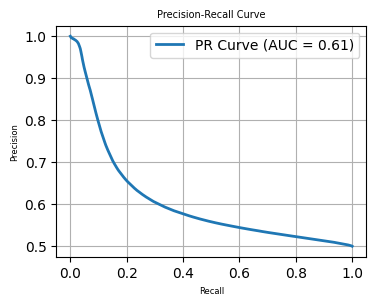

In [7]:
plotting_PR_AUC(seq_model, test_loader)

# Genomic promoter

In [6]:
BATCH_SIZE = 128
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor(),
    t.Reverse(0.5)
])
val_test_transform = t.Compose([
    #t.Seq2Tensor()
])
task = "genomicpromoter"
train_dataset = MassiveStarrDataset(task = task, split = "train",transform = train_transform)

val_dataset = MassiveStarrDataset(task = task, split = "val",transform = val_test_transform) 

test_dataset = MassiveStarrDataset(task = task, split = "test", transform = val_test_transform)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [7]:
test_dataset[4715]

('ttgtcctcattctagtatgtaggctgaccagagcagccaccaattggggattgccattacccatagtataaagaaaaagaaagcatagcaaatcatagtgaactttcttaaatcatccat',
 np.float32(0.0))

In [8]:
seq_model = Seq1Model(seq_len=len(train_dataset[0][0][0]), lr = 3e-3)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=20,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = False,
    #callbacks=[TQDMProgressBar(refresh_rate=55)]
    #logger = logger
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-02-05 18:44:02.298750: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-05 18:44:02.314569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one 

TypeError: conv1d() received an invalid combination of arguments - got (tuple, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!tuple of (str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str)!, !Parameter!,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.85
Recall (при пороге 0.5): 0.88
PR-AUC (correct): 0.95
PR-AUC: 0.95


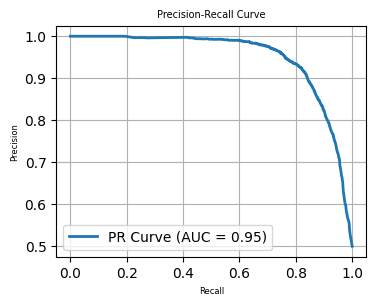

In [22]:
plotting_PR_AUC(seq_model, val_loader)

In [18]:
act = nn.Sigmoid()
    #get predicted values
y_preds = trainer.predict(seq_model, dataloaders=test_loader)
y_preds = torch.concat(y_preds).cpu().numpy()
y_preds = torch.tensor(y_preds).squeeze()
    #get target values
targets = []
for i, batch in enumerate(test_loader):
    x, y = batch
    targets.append(y)
targets = torch.tensor(torch.concat(targets).cpu().numpy())
y_preds = act(y_preds)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


In [19]:
len(y_preds[y_preds > 0.5])

1226

# Promoter capture

In [9]:
BATCH_SIZE = 512
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])
task = "CapturePromoter"
train_dataset = MassiveStarrDataset(task = task, split = "train",transform = train_transform)

val_dataset = MassiveStarrDataset(task = task, split = "val",transform = val_test_transform) 

test_dataset = MassiveStarrDataset(task = task, split = "test", transform = val_test_transform)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [10]:
seq_model = Seq1Model(seq_len=len(train_dataset[0][0][0]), lr = 0.01)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=5,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = False,
    #callbacks=[TQDMProgressBar(refresh_rate=55)]
    #logger = logger
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | Simple_Net        | 21.3 K | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
21.3 K    Trainable params
0         Non-trainable params
21.3 K    Total params
0.085     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode



----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.69866 |
----------------------------------------------


----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.59919 |
----------------------------------------------


----------------------------------------------
| current_epoch: 1.00000 | val_loss: 0.55338 |
----------------------------------------------


----------------------------------------------
| current_epoch: 2.00000 | val_loss: 0.55768 |
----------------------------------------------


----------------------------------------------
| current_epoch: 3.00000 | val_loss: 0.55359 |
----------------------------------------------



`Trainer.fit` stopped: `max_epochs=5` reached.



----------------------------------------------
| current_epoch: 4.00000 | val_loss: 0.55898 |
----------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.85
Recall (при пороге 0.5): 0.83
PR-AUC: 0.92


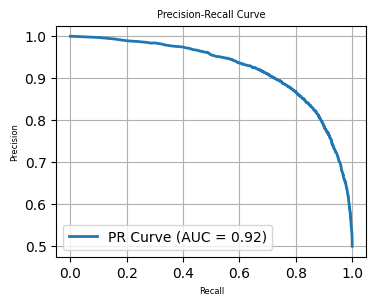

In [52]:
plotting_PR_AUC(seq_model, test_loader)

# Genome enhancer

In [10]:
BATCH_SIZE = 1024
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])
task = "GenomicEnhancer"
train_dataset = MassiveStarrDataset(task = task, split = "train",transform = train_transform)

val_dataset = MassiveStarrDataset(task = task, split = "val",transform = val_test_transform) 

test_dataset = MassiveStarrDataset(task = task, split = "test", transform = val_test_transform)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [6]:
seq_model = Seq1Model(seq_len=len(train_dataset[0][0][0]), lr = 0.01)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=5,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = False,
    #callbacks=[TQDMProgressBar(refresh_rate=55)]
    #logger = logger
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-12-22 21:25:48.873007: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-22 21:25:48.888167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one 


----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.62637 |
----------------------------------------------


----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.56372 |
----------------------------------------------


----------------------------------------------
| current_epoch: 1.00000 | val_loss: 0.55484 |
----------------------------------------------


----------------------------------------------
| current_epoch: 2.00000 | val_loss: 0.53585 |
----------------------------------------------


----------------------------------------------
| current_epoch: 3.00000 | val_loss: 0.52830 |
----------------------------------------------



`Trainer.fit` stopped: `max_epochs=5` reached.



----------------------------------------------
| current_epoch: 4.00000 | val_loss: 0.54086 |
----------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.81
Recall (при пороге 0.5): 0.63
PR-AUC: 0.84


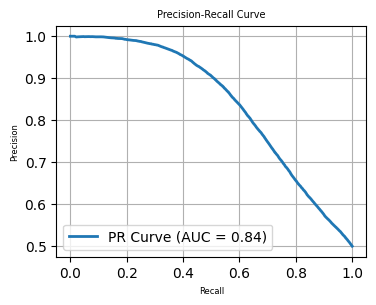

In [7]:
plotting_PR_AUC(seq_model, test_loader)

# ATACseq

In [11]:
BATCH_SIZE = 2048
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])
task = "atacseq"
train_dataset = MassiveStarrDataset(task = task, split = "train",transform = train_transform)

val_dataset = MassiveStarrDataset(task = task, split = "val",transform = val_test_transform) 

test_dataset = MassiveStarrDataset(task = task, split = "test", transform = val_test_transform)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [37]:
seq_model = Seq1Model(seq_len=len(train_dataset[0][0][0]), lr = 0.01)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=5,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = False,
    #callbacks=[TQDMProgressBar(refresh_rate=55)]
    #logger = logger
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | Simple_Net        | 540 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
540 K     Trainable params
0         Non-trainable params
540 K     Total params
2.162     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode



----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.72036 |
----------------------------------------------


----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.39401 |
----------------------------------------------


----------------------------------------------
| current_epoch: 1.00000 | val_loss: 0.38693 |
----------------------------------------------


----------------------------------------------
| current_epoch: 2.00000 | val_loss: 0.37577 |
----------------------------------------------


----------------------------------------------
| current_epoch: 3.00000 | val_loss: 0.37593 |
----------------------------------------------



`Trainer.fit` stopped: `max_epochs=5` reached.



----------------------------------------------
| current_epoch: 4.00000 | val_loss: 0.38308 |
----------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.86
Recall (при пороге 0.5): 0.73
PR-AUC: 0.90


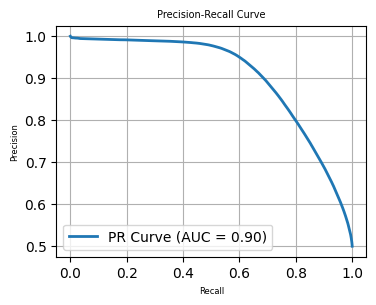

In [38]:
plotting_PR_AUC(seq_model, test_loader)

# Differential Expression task

In [6]:
class diff_expr_net(nn.Module):
    
    def __init__(self, output_dim = 1, seq_len = 150, in_ch = 4, block_sizes=[256]
, kernel_size=7):
        
        super().__init__()
        self.seq_len = seq_len
        self.in_ch = in_ch
        self.out_ch = output_dim
        out_ch = 64
        nn_blocks = []
      
        for in_bs, out_bs in zip([in_ch] + block_sizes, block_sizes):
            
            block = nn.Sequential(
                nn.Conv1d(in_bs, out_bs, kernel_size=kernel_size, padding=1),
                nn.SiLU(),
                nn.BatchNorm1d(out_bs)
            )
            nn_blocks.append(block)
            
        self.conv_net = nn.Sequential(
            *nn_blocks,
            nn.Flatten(),
            nn.Linear(block_sizes[-1] * (seq_len + len(block_sizes)*(3-kernel_size)), out_ch),
        )
        self.head = nn.Sequential(nn.Linear(out_ch, out_ch),
                                   nn.BatchNorm1d(out_ch),
                                   nn.SiLU(),
                                   nn.Linear(out_ch, self.out_ch))

    def forward(self, x):
       
        out = self.conv_net(x)
        out = self.head(out)
        
        return out
        

In [7]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

def initialize_weights(m):
    if isinstance(m, nn.Conv1d):
        n = m.kernel_size[0] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2 / n))
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.001)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

class SELayer(nn.Module):
    def __init__(self, inp, reduction=4):
        super(SELayer, self).__init__()
        self.fc = nn.Sequential(
                nn.Linear(inp, int(inp // reduction)),
                nn.SiLU(),
                nn.Linear(int(inp // reduction), inp),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, = x.size()
        y = x.view(b, c, -1).mean(dim=2)
        y = self.fc(y).view(b, c, 1)
        return x * y

class EffBlock(nn.Module):
    def __init__(self, in_ch, ks, resize_factor, activation, out_ch=None, se_reduction=None):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = self.in_ch if out_ch is None else out_ch
        self.resize_factor = resize_factor
        self.se_reduction = resize_factor if se_reduction is None else se_reduction
        self.ks = ks
        self.inner_dim = self.in_ch * self.resize_factor

        block = nn.Sequential(
                        nn.Conv1d(
                            in_channels=self.in_ch,
                            out_channels=self.inner_dim,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.inner_dim),
                       activation(),

                       nn.Conv1d(
                            in_channels=self.inner_dim,
                            out_channels=self.inner_dim,
                            kernel_size=ks,
                            groups=self.inner_dim,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.inner_dim),
                       activation(),
                       SELayer(self.inner_dim, reduction=self.se_reduction),
                       nn.Conv1d(
                            in_channels=self.inner_dim,
                            out_channels=self.in_ch,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.in_ch),
                       activation(),
        )

        self.block = block

    def forward(self, x):
        return self.block(x)

class LocalBlock(nn.Module):
    def __init__(self, in_ch, ks, activation, out_ch=None):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = self.in_ch if out_ch is None else out_ch
        self.ks = ks

        self.block = nn.Sequential(
                       nn.Conv1d(
                            in_channels=self.in_ch,
                            out_channels=self.out_ch,
                            kernel_size=self.ks,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.out_ch),
                       activation()
        )

    def forward(self, x):
        return self.block(x)

class ResidualConcat(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return torch.concat([self.fn(x, **kwargs), x], dim=1)

class MapperBlock(nn.Module):
    def __init__(self, in_features, out_features, activation=nn.SiLU):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Conv1d(in_channels=in_features,
                      out_channels=out_features,
                      kernel_size=1),
        )

    def forward(self, x):
        return self.block(x)

class HumanLegNet(nn.Module):
    def __init__(self,
                 in_ch,
                 stem_ch,
                 stem_ks,
                 ef_ks,
                 ef_block_sizes,
                 pool_sizes,
                 resize_factor,
                 activation=nn.SiLU,
                 ):
        super().__init__()
        assert len(pool_sizes) == len(ef_block_sizes)

        self.in_ch = in_ch
        self.stem = LocalBlock(in_ch=in_ch,
                               out_ch=stem_ch,
                               ks=stem_ks,
                               activation=activation)

        blocks = []

        in_ch = stem_ch
        out_ch = stem_ch
        for pool_sz, out_ch in zip(pool_sizes, ef_block_sizes):
            blc = nn.Sequential(
                ResidualConcat(
                    EffBlock(
                        in_ch=in_ch,
                        out_ch=in_ch,
                        ks=ef_ks,
                        resize_factor=resize_factor,
                        activation=activation)
                ),
                LocalBlock(in_ch=in_ch * 2,
                           out_ch=out_ch,
                           ks=ef_ks,
                           activation=activation),
                nn.MaxPool1d(pool_sz) if pool_sz != 1 else nn.Identity()
            )
            in_ch = out_ch
            blocks.append(blc)
        self.main = nn.Sequential(*blocks)

        self.mapper = MapperBlock(in_features=out_ch,
                                  out_features=out_ch * 2)
        self.head = nn.Sequential(nn.Linear(out_ch * 2, out_ch * 2),
                                   nn.BatchNorm1d(out_ch * 2),
                                   activation(),
                                   nn.Linear(out_ch * 2, 1))

    def forward(self, x):
        x = self.stem(x)
        x = self.main(x)
        x = self.mapper(x)
        x =  F.adaptive_avg_pool1d(x, 1)
        x = x.squeeze(-1)
        x = self.head(x)
        x = x.squeeze(-1)
        return x

In [8]:
BATCH_SIZE = 64
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor(),
    t.Reverse(0.5)
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])

task = tasks[5]
length = 150

train_dataset = MassiveStarrDataset(task = task, split = "train", length = length, transform = train_transform)

val_dataset = MassiveStarrDataset(task = task, split = "val", length = length, transform = val_test_transform) 

test_dataset = MassiveStarrDataset(task = task, split = "test", length = length, transform = val_test_transform)


In [9]:
print(train_dataset)
print("="*20)
print(val_dataset)
print("="*20)
print(test_dataset)

Dataset MassiveStarrDataset of size 8230 (MpraDaraset)
    Number of datapoints: 8230
    Default split folds: {}
    Used split fold: ['chr1', 'chr3', 'chr5', 'chr7', 'chr9', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
    Scalar features: {}
    Vector features: {}
    Cell types: None
    Сell type used: None
    Target columns that can be used: {}
    Number of channels: 150
    Sequence size: 1
    Number of samples: {}
    Description: MassiveStarrDataset is based on 
Dataset MassiveStarrDataset of size 1467 (MpraDaraset)
    Number of datapoints: 1467
    Default split folds: {}
    Used split fold: ['chr4', 'chr6', 'chr8']
    Scalar features: {}
    Vector features: {}
    Cell types: None
    Сell type used: None
    Target columns that can be used: {}
    Number of channels: 150
    Sequence size: 1
    Number of samples: {}
    Description: MassiveStarrDataset is based on 
Dataset MassiveStarrDataset of size 2041 (MpraDa

In [10]:
import pytorch_lightning as L
from torch.nn import functional as F

def pearson_correlation(x, y):
    vx = x - torch.mean(x, dim=0)
    vy = y - torch.mean(y, dim=0)
    pearsons = torch.sum(vx * vy, dim=0) / (torch.sqrt(torch.sum(vx ** 2, dim=0)) * torch.sqrt(torch.sum(vy ** 2, dim=0)) + 1e-10)
    return torch.mean(pearsons)
    
class SeqModel(L.LightningModule):
    
    def __init__(self, seq_len, lr=3e-4):
        super().__init__()
        self.model = diff_expr_net(seq_len = seq_len)
        '''
        self.model = HumanLegNet(in_ch=4,
                                 stem_ch=64,
                                 stem_ks=11,
                                 ef_ks=9,
                                 ef_block_sizes=[80, 96, 112, 128],
                                 pool_sizes=[2,2,2,2],
                                 resize_factor=4)
        self.model.apply(initialize_weights)
        '''
        self.loss = nn.MSELoss().cuda()
        self.lr = lr
        self.val_loss = []
        self.val_pears = []

        self.train_loss = []
        self.train_pears = []
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        X, y = batch
        y_hat = self.model(X).squeeze().cuda()
        y = y.cuda()
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True,  on_step=True, on_epoch=True, logger = True)
        self.train_loss.append(loss)

        corr = pearson_correlation(y_hat, y)
        self.train_pears.append(corr)
        
        lr = self.optimizers().param_groups[0]['lr']  # Get current learning rate
        self.log('learning_rate', lr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x).squeeze().cuda()
        y = y.cuda()
        loss = self.loss(y_hat, y)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_loss.append(loss)

        corr = pearson_correlation(y_hat, y)
        self.val_pears.append(corr)
        self.log("val_pearson", corr, on_epoch=True, prog_bar=True, on_step = False)
        
    def on_validation_epoch_end(self):

        val_loss = torch.stack(self.val_loss, dim = 0).mean()
        val_pears = torch.stack(self.val_pears, dim = 0).mean()
        if len(self.train_loss) != 0:
            train_loss = torch.stack(self.train_loss, dim = 0).mean()
            train_pears = torch.stack(self.train_pears, dim = 0).mean()
        
        res_str = '|' + ' {}: {:.5f} |'.format("current_epoch", self.current_epoch) 
        res_str += ' {}: {:.5f} |'.format("val_loss", val_loss)
        res_str += ' {}: {:.5f} |'.format("val_pearson", val_pears)
        if len(self.train_loss) != 0:
            res_str += ' {}: {:.5f} |'.format("train_loss", train_loss)
            res_str += ' {}: {:.5f} |'.format("train_pearson", train_pears)
        border = '-'*len(res_str)
        print("\n".join(['',border, res_str, border,'']))
        self.val_loss.clear()
        self.val_pears.clear()
        if len(self.train_loss) != 0:
            self.train_loss.clear()
            self.train_pears.clear()
        return None
        
    def test_step(self, batch, _):
        x, y = batch
        y_hat = self.model(x).squeeze()
        loss = self.loss(y_hat, y)
        
        self.log('test_loss', 
                 loss, 
                 prog_bar=True, 
                 on_step=False,
                 on_epoch=True)
        corr = pearson_correlation(y_hat, y)
        self.log("test_pearson", 
                 corr ,
                 on_epoch=True,
                 prog_bar=True,
                 on_step=False,)
        
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        if isinstance(batch, tuple) or isinstance(batch, list):
            x, _ = batch
        else:
            x = batch
        return self(x)

    def train_dataloader(self):
        
        return data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS)

    def val_dataloader(self):
        
        return data.DataLoader(dataset = val_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)
    
    def test_dataloader(self):
        
        return data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)
        
    '''
    def configure_optimizers(self):
        
        self.optimizer = torch.optim.AdamW(self.parameters(),
                                               lr=self.lr,
                                               weight_decay = 0.001)
        
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, # type: ignore
                                                        max_lr=self.lr,
                                                        three_phase=False, 
                                                        total_steps=self.trainer.estimated_stepping_batches, # type: ignore
                                                        pct_start=0.3,
                                                        cycle_momentum =False)
        lr_scheduler_config = {
                    "scheduler": lr_scheduler,
                    "interval": "step",
                    "frequency": 1,
                    "name": "cycle_lr"
            }
            
        return [self.optimizer], [lr_scheduler_config]
    '''

    def configure_optimizers(self):
        
        self.optimizer = torch.optim.Adam(self.parameters(),
                                               lr=self.lr,
                                               weight_decay = 0.001)
        return self.optimizer
    

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.77E-05


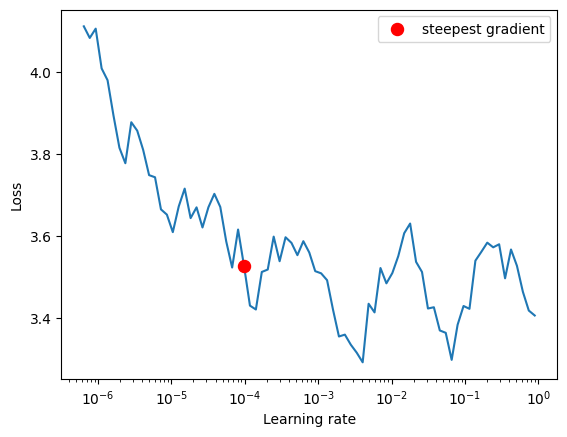

In [13]:
from torch_lr_finder import LRFinder
import matplotlib.pyplot as plt

model = diff_expr_net(seq_len=len(train_dataset[0][0][0]))
'''
model = HumanLegNet(in_ch=4,
                                 stem_ch=64,
                                 stem_ks=11,
                                 ef_ks=9,
                                 ef_block_sizes=[80, 96, 112, 128],
                                 pool_sizes=[2,2,2,2],
                                 resize_factor=4)
'''
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay = 1e-3,)

criterion = nn.MSELoss() 
train_loader = data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, start_lr=1e-7, end_lr=10, num_iter=100)

lr_finder.plot()  
plt.show()

In [ ]:
seq_model = SeqModel(seq_len=len(train_dataset[0][0][0]), lr = 9.77E-05)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=50,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    #callbacks=[TQDMProgressBar(refresh_rate=55)]
    #logger = logger
)

# Train the model
trainer.fit(seq_model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-02-11 12:39:45.051249: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-11 12:39:45.067780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one 

Sanity Checking: |                                                                             | 0/? [00:00<?,…


---------------------------------------------------------------------
| current_epoch: 0.00000 | val_loss: 3.25751 | val_pearson: 0.03820 |
---------------------------------------------------------------------



Training: |                                                                                    | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------------------------------------------------------------------------------
| current_epoch: 0.00000 | val_loss: 4.55771 | val_pearson: -0.02444 | train_loss: 3.56216 | train_pearson: -0.01544 |
----------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


---------------------------------------------------------------------------------------------------------------------
| current_epoch: 1.00000 | val_loss: 4.51995 | val_pearson: -0.02081 | train_loss: 3.30842 | train_pearson: 0.16025 |
---------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


--------------------------------------------------------------------------------------------------------------------
| current_epoch: 2.00000 | val_loss: 4.49260 | val_pearson: 0.02355 | train_loss: 3.20720 | train_pearson: 0.25290 |
--------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


--------------------------------------------------------------------------------------------------------------------
| current_epoch: 3.00000 | val_loss: 4.51684 | val_pearson: 0.00542 | train_loss: 3.15531 | train_pearson: 0.30422 |
--------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


--------------------------------------------------------------------------------------------------------------------
| current_epoch: 4.00000 | val_loss: 4.53558 | val_pearson: 0.01082 | train_loss: 3.09804 | train_pearson: 0.34633 |
--------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


--------------------------------------------------------------------------------------------------------------------
| current_epoch: 5.00000 | val_loss: 4.48967 | val_pearson: 0.02695 | train_loss: 3.04628 | train_pearson: 0.37404 |
--------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


---------------------------------------------------------------------------------------------------------------------
| current_epoch: 6.00000 | val_loss: 4.57407 | val_pearson: -0.00324 | train_loss: 3.04849 | train_pearson: 0.37236 |
---------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


---------------------------------------------------------------------------------------------------------------------
| current_epoch: 7.00000 | val_loss: 4.57448 | val_pearson: -0.01690 | train_loss: 3.01802 | train_pearson: 0.39969 |
---------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


--------------------------------------------------------------------------------------------------------------------
| current_epoch: 8.00000 | val_loss: 4.54464 | val_pearson: 0.00861 | train_loss: 3.00039 | train_pearson: 0.40203 |
--------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


---------------------------------------------------------------------------------------------------------------------
| current_epoch: 9.00000 | val_loss: 4.60918 | val_pearson: -0.02262 | train_loss: 2.97750 | train_pearson: 0.41041 |
---------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------------------------------------------------------------------------------
| current_epoch: 10.00000 | val_loss: 4.61925 | val_pearson: -0.02390 | train_loss: 2.96489 | train_pearson: 0.42082 |
----------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


---------------------------------------------------------------------------------------------------------------------
| current_epoch: 11.00000 | val_loss: 4.56110 | val_pearson: 0.01214 | train_loss: 2.94076 | train_pearson: 0.42920 |
---------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


---------------------------------------------------------------------------------------------------------------------
| current_epoch: 12.00000 | val_loss: 4.54532 | val_pearson: 0.02396 | train_loss: 2.95168 | train_pearson: 0.42673 |
---------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------------------------------------------------------------------------------
| current_epoch: 13.00000 | val_loss: 4.62059 | val_pearson: -0.00169 | train_loss: 2.94462 | train_pearson: 0.42583 |
----------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


---------------------------------------------------------------------------------------------------------------------
| current_epoch: 14.00000 | val_loss: 4.58575 | val_pearson: 0.01060 | train_loss: 2.94402 | train_pearson: 0.42640 |
---------------------------------------------------------------------------------------------------------------------



In [ ]:
trainer.test(seq_model)

# Binary task

In [6]:
import sklearn
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, average_precision_score
import matplotlib.pyplot as plt
def plotting_PR_AUC_binary(seq_model, test_loader):
    act = nn.Sigmoid()
    
    #get predicted values
    y_preds = trainer.predict(seq_model, test_loader)

    y_preds = torch.concat(y_preds)
    
    targets = []
    for i, batch in enumerate(test_loader):
        x, y = batch
        targets.append(y)
    targets = torch.tensor(torch.concat(targets).cpu().numpy())
    y_preds = act(y_preds)
    
    threshold = 0.5  # Пример порога
    y_true = targets.cpu().numpy()
    y_pred = (y_preds.numpy() >= threshold).astype(int)
    y_scores = y_preds.numpy()
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    prauc = average_precision_score(y_true, y_scores)
    
    print(f"Precision (при пороге {threshold}): {precision:.2f}")
    print(f"Recall (при пороге {threshold}): {recall:.2f}")
    print(f"PR-AUC (correct): {prauc:.2f}")
    
    # 2. Построение PR-кривой
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, y_scores)
    
    # Вычисление PR-AUC
    pr_auc = auc(recall_vals, precision_vals)
    
    print(f"PR-AUC: {pr_auc:.2f}")
    
    # 3. Построение графика PR-кривой
    plt.figure(figsize=(4,3))
    plt.plot(recall_vals, precision_vals, label=f'PR Curve (AUC = {pr_auc:.2f})', linewidth=2)
    plt.xlabel('Recall', fontsize=6)
    plt.ylabel('Precision', fontsize=6)
    plt.title('Precision-Recall Curve', fontsize=7)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [7]:
class binary_net(nn.Module):
    
    def __init__(self, block_sizes=[16, 32, 64, 96, 126, 64], kernel_size=5):
        
        super().__init__()
        nn_blocks = []
        self.block_sizes = block_sizes
        for in_bs, out_bs in zip([4] + block_sizes, block_sizes):
            
            block = nn.Sequential(
                nn.Conv1d(in_bs, out_bs, kernel_size=kernel_size, padding = kernel_size // 2), # Padding для сохранения размера
                nn.BatchNorm1d(out_bs),
                nn.SiLU(),
                nn.Dropout(0.3)
            )
            nn_blocks.append(block)
        
        self.conv_net = nn.Sequential(
            *nn_blocks,
            nn.Flatten()
        )
        
    def forward(self, x):
        out = self.conv_net(x)

        return out

In [8]:
BATCH_SIZE = 1024
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor(),
    t.Reverse(0.5)
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])
binary_train = ["promoter_from_input", "enhancer_permutated", "enhancer_from_input"]

task = tasks[6]

train_dataset = MassiveStarrDataset(task = task, binary_class = None, split = "train",transform = train_transform)

val_dataset = MassiveStarrDataset(task = task, split = "val",transform = val_test_transform) 

test_dataset = MassiveStarrDataset(task = task, split = "test", transform = val_test_transform)


using train
using val
using test


In [13]:
class binary_trainer(L.LightningModule):
    
    def __init__(self, seq_len, batch_size, lr=3e-4):
        super().__init__()
        self.model = binary_net()
        self.seq_len = seq_len
        self.loss = torch.nn.BCEWithLogitsLoss().cuda()
        self.lr = lr
        self.batch_size = batch_size
        self.val_loss = []
        final_feature_size = seq_len  # Размер последовательности остаётся неизменным из-за padding
        out_bs = 32
        self.last_block = nn.Sequential(
                nn.Linear(self.model.block_sizes[-1] * final_feature_size * 2, out_bs), # Padding для сохранения размера
                nn.BatchNorm1d(out_bs),
                nn.SiLU(),
                nn.Dropout(0.3),
                nn.Linear(out_bs, 1)
            )
        
        
    def forward(self, x):       
        return self.model(x)

    def training_step(self, batch, batch_nb):
        seqs, labels = batch
        
        enh_x = seqs["seq1"]
        prom_x = seqs["seq2"]
        
        enhancer = self(enh_x)
        promoter = self(prom_x)
        
        concat = torch.cat([enhancer, promoter], dim=1)
        out = self.last_block(concat).squeeze().cuda()
        
        loss = self.loss(out, labels)
        
        self.log("train_loss", loss, prog_bar=True,  on_step=True, on_epoch=True, logger = True, batch_size=self.batch_size)
        
        lr = self.optimizers().param_groups[0]['lr']  # Get current learning rate
        self.log('learning_rate', lr, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        seqs, labels = batch
        
        enh_x = seqs["seq1"]
        prom_x = seqs["seq2"]
        
        enhancer = self(enh_x)
        promoter = self(prom_x)
        
        concat = torch.cat([enhancer, promoter], dim=1)
        out = self.last_block(concat).squeeze().cuda()
    
        loss = self.loss(out, labels)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=self.batch_size)
        self.val_loss.append(loss)
        
    def on_validation_epoch_end(self):

        val_loss = torch.stack(self.val_loss, dim = 0).mean()
        
        res_str = '|' + ' {}: {:.5f} |'.format("current_epoch", self.current_epoch) 
        res_str += ' {}: {:.5f} |'.format("val_loss", val_loss)
        border = '-'*len(res_str)
        print("\n".join(['',border, res_str, border,'']))
        self.val_loss.clear()
        return None
        
    def test_step(self, batch):
        seqs, labels = batch
        
        enh_x = seqs["seq1"]
        prom_x = seqs["seq2"]
        
        enhancer = self(enh_x)
        promoter = self(prom_x)

        concat = torch.cat([enhancer, promoter], dim=1)

        out = self.last_block(concat).squeeze().cuda()

        loss = self.loss(out, labels)
        
        self.log('test_loss', 
                 loss, 
                 prog_bar=True, 
                 on_step=False,
                 on_epoch=True, batch_size=self.batch_size)
        
    def predict_step(self, batch, batch_idx, dataloader_idx = 0):
        seqs, labels = batch
        
        enh_x = seqs["seq1"]
        prom_x = seqs["seq2"]
        
        enhancer = self(enh_x)
        promoter = self(prom_x)

        concat = torch.cat([enhancer, promoter], dim=1)

        out = self.last_block(concat).squeeze().cuda()
        
        return out
        
    def train_dataloader(self):
        
        return data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS)

    def val_dataloader(self):
        
        return data.DataLoader(dataset = val_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)
    
    def test_dataloader(self):
        
        return data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)

    def configure_optimizers(self):
        
        self.optimizer = torch.optim.Adam(self.parameters(),
                                               lr=self.lr,
                                               weight_decay = 0.0001)
        return self.optimizer

In [14]:
seq_model = binary_trainer(seq_len = len(train_dataset[0][0]["seq1"][0]), lr = 3e-4, batch_size = BATCH_SIZE)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=10,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    #callbacks=[TQDMProgressBar(refresh_rate=55)]
    #logger = logger
)

# Train the model

trainer.fit(seq_model)
#trainer.test(seq_model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | model      | binary_net        | 145 K  | train
1 | loss       | BCEWithLogitsLoss | 0      | train
2 | last_block | Sequential        | 614 K  | train
---------------------------------------------------------
760 K     Trainable params
0         Non-trainable params
760 K     Total params
3.041     Total estimated model params size (MB)
40        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                             | 0/? [00:00<?,…


----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.67441 |
----------------------------------------------



Training: |                                                                                    | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.66178 |
----------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------
| current_epoch: 1.00000 | val_loss: 0.61373 |
----------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------
| current_epoch: 2.00000 | val_loss: 0.60652 |
----------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------
| current_epoch: 3.00000 | val_loss: 0.60460 |
----------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------
| current_epoch: 4.00000 | val_loss: 0.57859 |
----------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------
| current_epoch: 5.00000 | val_loss: 0.56611 |
----------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------
| current_epoch: 6.00000 | val_loss: 0.56265 |
----------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------
| current_epoch: 7.00000 | val_loss: 0.56404 |
----------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------
| current_epoch: 8.00000 | val_loss: 0.56841 |
----------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…

`Trainer.fit` stopped: `max_epochs=10` reached.



----------------------------------------------
| current_epoch: 9.00000 | val_loss: 0.59102 |
----------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                  | 0/? [00:00<?,…

Precision (при пороге 0.5): 0.86
Recall (при пороге 0.5): 0.48
PR-AUC (correct): 0.82
PR-AUC: 0.82


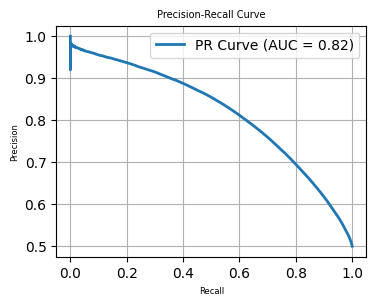

In [15]:
val_loader = data.DataLoader(dataset = val_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)
plotting_PR_AUC_binary(seq_model, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                  | 0/? [00:00<?,…

Precision (при пороге 0.5): 0.86
Recall (при пороге 0.5): 0.48
PR-AUC (correct): 0.82
PR-AUC: 0.82


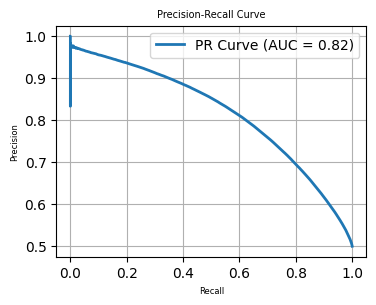

In [16]:
test_loader = data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)
plotting_PR_AUC_binary(seq_model, test_loader)